# SafeHarbor Trading Company
### Crytocurrency Algorithmic Trading and Bot Advisor

Several factors play into investing in any asset class.  In comparison, investing in stocks versus cyptocurrency require different approaches because the difference in inherent value.  With regard to investing in stock, an individual would consider the individual companies health by analyzing its financial statements (income, balance sheet, and cash flow statement).  Then, an individual might consider the technical factors related to that company’s stock, such as its historical price performance, returns, and volatility.  Since all of these factors are affected by the company’s performance, its effectiveness and efficiency of producing a quality product or service to the market stabilizes its inherent value.  The relative performance of producing this product or service helps to establish its inherent value.  In contrast, most cyptocurrencies lack the inherent value of producing a proven product or service repeatedly to a market, creating greater volatility.  The stability or volatility improves when we consider stable coins and coins that have greater utility and/or functionality.

In [3]:
# Imports Dependencies and Libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

# Import functions from the folder Utilites
from Utilities import utils as u

%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

### Imported the dataset into a Pandas DataFrame from spreadsheet for baseline source information

In [7]:
# Read the SafeHarbor_coins.csv file into Pandas DataFrame
# Set the `date` column as the DateTimeIndex
df = pd.read_csv(
    Path("./Resources/SafeHarbor_coins.csv"), 
    index_col="dates",
    parse_dates=True, 
    infer_datetime_format=True
)

# Review the DataFrame
df.head()

,coin,date,prices,market_caps,total_vol
dates,,,,,
2021-12-31,bitcoin,1.640995e+12,46319.651088,8.761929e+11,2.589535e+10
2022-01-01,bitcoin,1.641082e+12,47816.077676,9.045519e+11,1.890459e+10
2022-01-02,bitcoin,1.641168e+12,47387.212168,8.975361e+11,3.375613e+10
2022-01-03,bitcoin,1.641254e+12,46531.140861,8.803302e+11,2.189002e+10
2022-01-04,bitcoin,1.641341e+12,45938.024272,8.762427e+11,2.489599e+10


In [8]:
#drop the column titled "date"
df.drop(columns=["date"])

,coin,prices,market_caps,total_vol
dates,,,,
2021-12-31,bitcoin,46319.651088,8.761929e+11,2.589535e+10
2022-01-01,bitcoin,47816.077676,9.045519e+11,1.890459e+10
2022-01-02,bitcoin,47387.212168,8.975361e+11,3.375613e+10
2022-01-03,bitcoin,46531.140861,8.803302e+11,2.189002e+10
2022-01-04,bitcoin,45938.024272,8.762427e+11,2.489599e+10
...,...,...,...,...
2022-11-03,litecoin,61.977356,4.423794e+09,1.856214e+09
2022-11-04,litecoin,67.564797,4.830118e+09,1.988837e+09
2022-11-05,litecoin,69.655678,5.012880e+09,1.813550e+09


In [9]:
# Create a DataFrame filtering only the index and prices columns
signals_df = df.loc[:,["coin","prices"]].round(6)

# Review the DataFrame
signals_df

,coin,prices
dates,,
2021-12-31,bitcoin,46319.651088
2022-01-01,bitcoin,47816.077676
2022-01-02,bitcoin,47387.212168
2022-01-03,bitcoin,46531.140861
2022-01-04,bitcoin,45938.024272
...,...,...
2022-11-03,litecoin,61.977356
2022-11-04,litecoin,67.564797
2022-11-05,litecoin,69.655678


In [10]:
#use the groupby function to display mean, max, and min of original DF signals_df

data_avg = signals_df.groupby('coin')['prices'].mean()

display(data_avg.head())

data_max = signals_df.groupby('coin')['prices'].max()

display(data_max.tail())

data_min = signals_df.groupby('coin')['prices'].min()

display(data_min.head())


coin
avalanche-2       45.541832
binance-usd        1.000702
binancecoin      334.046991
bitcoin        30244.519946
cardano            0.704167
Name: prices, dtype: float64

coin
tether                 1.007038
tron                   0.087760
uniswap               18.438002
usd-coin               1.010925
wrapped-bitcoin    47765.557296
Name: prices, dtype: float64

coin
avalanche-2       14.897482
binance-usd        0.995359
binancecoin      197.376506
bitcoin        18539.635238
cardano            0.340137
Name: prices, dtype: float64

In [30]:
#Sort the mean values
data_avg_sorted = data_avg.sort_values()

# pass the values into a new dataframe
data_avg_sorted_df = pd.DataFrame(data_avg_sorted)

#display dataframe
data_avg_sorted_df


,prices
coin,
shiba-inu,0.000017
tron,0.066229
dogecoin,0.100381
ripple,0.538551
cardano,0.704167
usd-coin,1.000595
dai,1.000640
tether,1.000649
binance-usd,1.000702


In [17]:
#with this visualization we can dig a little deeper. We can See that bitcoin and wrapped-bitcion have the highest mean prices over the period of
#time in this data set. Crontrary, shiba-inu has the lowest. 
data_avg_sorted_df.hvplot.bar(xlabel="coins", ylabel="prices", rot=0, invert=True, title="Mean Prices of Crypto Currencies")

:Bars   [coin]   (prices)

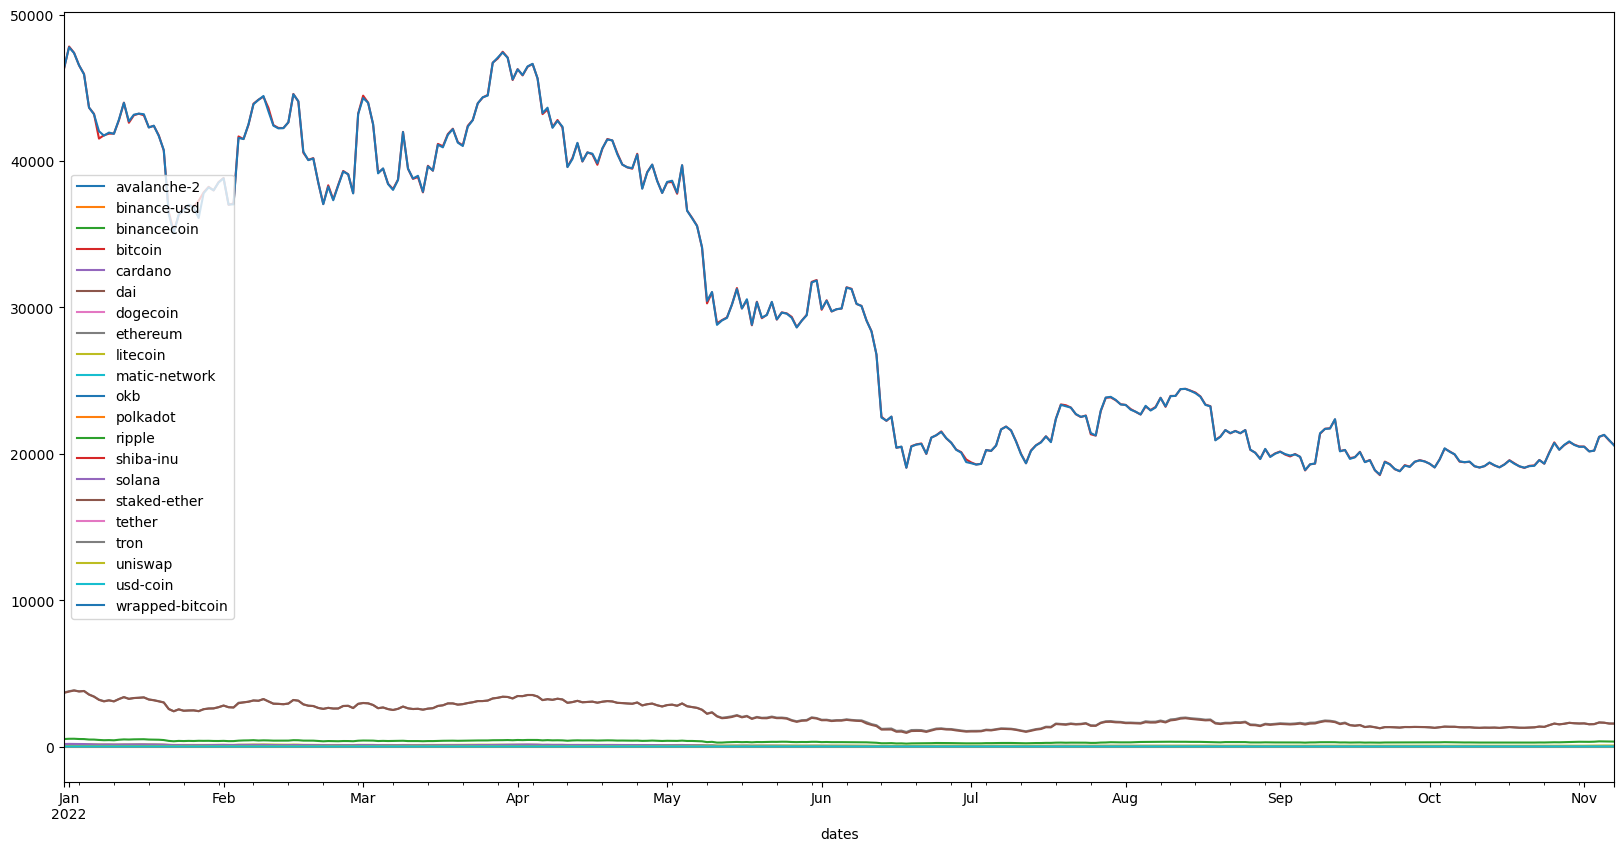

In [27]:
crypto_data_plot = signals_df.groupby('coin')['prices'].plot(legend=True, figsize=(20, 10))

In [28]:
#make a Standard Deviation Dataframe

std_df = pd.DataFrame()

#use the groupby function with a for loop in order to caculate the standard deviation. In the for loop cocat the new dataframs into one data frame. 
#rename colums and apply the dropna functio. 
group_coin_price = signals_df.groupby(['coin'])
for coin in signals_df['coin'].unique():
    block = (group_coin_price.get_group(coin)['prices'].rolling(window=5).std())
    block_1 = (group_coin_price.get_group(coin)['prices'].rolling(window=5).mean())
    block_2 =pd.concat([block,block_1],axis=1)
    std_df = pd.concat([std_df,block_2], axis=0)
std_df['coin']=signals_df['coin']
std_df.columns=['std','mean','coin']
std_df=std_df.dropna()

std_df

,std,mean,coin
dates,,,
2022-01-04,778.338291,46798.421213,bitcoin
2022-01-05,1635.244021,46263.920497,bitcoin
2022-01-06,1826.377883,45343.996697,bitcoin
2022-01-07,2053.527415,44171.993672,bitcoin
2022-01-08,1773.204752,43217.097965,bitcoin
...,...,...,...
2022-11-03,3.338029,57.598440,litecoin
2022-11-04,5.225899,60.036314,litecoin
2022-11-05,5.801448,62.952592,litecoin


In [29]:
#groupby and Hvplot the std_df in order to see a side by side 
#comparison of each coin in relationship with the Standard Deviation and the Mean
std_df.hvplot.line(groupby=("coin"), ylabel="price", xlabel="date/time", title="Currencies Closing Prices")

:DynamicMap   [coin]
   :NdOverlay   [Variable]
      :Curve   [dates]   (value)

### Generated Portfolio-Level Risk/Reward Evaluation Metrics

In [8]:
# Create a list for the column name
columns = df['coin'].unique()

# Create a list holding the names of the new evaluation metrics
metrics = [
    'Annualized Return',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

# Initialize the DataFrame with index set to the evaluation metrics and the column
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the DataFrame
portfolio_evaluation_df.head()


grouped=signals_df.groupby('coin')
for coin in portfolio_evaluation_df.columns:
    # Calculate annualized return
    daily_returns=grouped.get_group(coin)['prices'].pct_change()
    portfolio_evaluation_df[coin].loc['Annualized Return'] = (
        daily_returns.mean() * 252
    )
    # Calculate annual volatility
    portfolio_evaluation_df[coin].loc['Annual Volatility'] = (
        daily_returns.std() * np.sqrt(252)
    )
    # Calculate Sharpe ratio
    portfolio_evaluation_df[coin].loc['Sharpe Ratio'] = (
    daily_returns.mean() * 252) / (
    daily_returns.std() * np.sqrt(252)
)
    #Calculate Sortino ratio
    portfolio_evaluation_df[coin].loc['Sortino Ratio']=u.sortino_ratio(daily_returns)
portfolio_evaluation_df.T

,Annualized Return,Annual Volatility,Sharpe Ratio,Sortino Ratio
bitcoin,-0.514709,0.529711,-0.971678,-1.29776
ethereum,-0.436748,0.711252,-0.614056,-0.842925
tether,0.001967,0.024775,0.079385,0.116484
binancecoin,-0.169901,0.575969,-0.294983,-0.392456
usd-coin,0.00117,0.034323,0.034097,0.047913
binance-usd,0.002129,0.037963,0.056075,0.080504
ripple,-0.236886,0.684224,-0.346211,-0.503191
cardano,-0.655633,0.768495,-0.853139,-1.172156
dogecoin,0.014932,0.867079,0.017221,0.026673
matic-network,-0.127995,0.948342,-0.134967,-0.198984


In [9]:
portfolio_evaluation_df.T.sort_values(by='Sharpe Ratio')

,Annualized Return,Annual Volatility,Sharpe Ratio,Sortino Ratio
solana,-1.014257,0.888676,-1.141312,-1.510352
avalanche-2,-1.025815,0.916754,-1.118964,-1.458458
wrapped-bitcoin,-0.516441,0.530047,-0.974331,-1.301441
bitcoin,-0.514709,0.529711,-0.971678,-1.29776
polkadot,-0.759136,0.782794,-0.969777,-1.285679
cardano,-0.655633,0.768495,-0.853139,-1.172156
ethereum,-0.436748,0.711252,-0.614056,-0.842925
staked-ether,-0.4297,0.71894,-0.597686,-0.821112
litecoin,-0.382696,0.691825,-0.553169,-0.740288
uniswap,-0.322835,0.890788,-0.362415,-0.508946


#### Algo-trading Is Technical Fun

In [10]:
# Use hvplot to visualize the DataFrame
signals_df.hvplot()

:Curve   [dates]   (prices)

### Backtest of the algorithm that uses Dual Moving Average Crossover (DMAC) trading approach

In [11]:
# Set the short_window (50) and long window (100) variables
short_window = 50
long_window = 100


In [12]:
# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df['SMA50'] = signals_df['prices'].rolling(window=short_window).mean()
signals_df['SMA100'] = signals_df['prices'].rolling(window=long_window).mean()

# Review the DataFrame
signals_df.tail()

,coin,prices,SMA50,SMA100
dates,,,,
2022-11-03,litecoin,61.977356,53.732342,56.389224
2022-11-04,litecoin,67.564797,53.959388,56.475735
2022-11-05,litecoin,69.655678,54.237659,56.537906
2022-11-06,litecoin,67.939525,54.441086,56.606322
2022-11-07,litecoin,67.728240,54.737887,56.679998


In [13]:
# Initialize the new Signal column to hold the trading signal
signals_df['Signal'] = 0.0


In [14]:
# Generate the trading signal 0 or 1,
# where 1 is the short-window (SMA50) is less than the long-window (SMA100)
signals_df["Signal"][short_window:] = np.where(
    signals_df["SMA50"][short_window:] < signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Review the DataFrame
signals_df.iloc[0:181,:].round(2)

,coin,prices,SMA50,SMA100,Signal
dates,,,,,
2021-12-31,bitcoin,46319.65,NaN,NaN,0.0
2022-01-01,bitcoin,47816.08,NaN,NaN,0.0
2022-01-02,bitcoin,47387.21,NaN,NaN,0.0
2022-01-03,bitcoin,46531.14,NaN,NaN,0.0
2022-01-04,bitcoin,45938.02,NaN,NaN,0.0
...,...,...,...,...,...
2022-06-25,bitcoin,21525.88,27740.97,34762.37,1.0
2022-06-26,bitcoin,21052.81,27450.56,34554.53,1.0
2022-06-27,bitcoin,20751.48,27184.18,34340.02,1.0


In [15]:
# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
signals_df.loc["2021-12-31":"2022-06-29",:]

,coin,prices,SMA50,SMA100,Signal,Entry/Exit
dates,,,,,,
2021-12-31,bitcoin,46319.651088,NaN,NaN,0.0,NaN
2022-01-01,bitcoin,47816.077676,NaN,NaN,0.0,0.0
2022-01-02,bitcoin,47387.212168,NaN,NaN,0.0,0.0
2022-01-03,bitcoin,46531.140861,NaN,NaN,0.0,0.0
2022-01-04,bitcoin,45938.024272,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...
2022-06-25,litecoin,58.865695,63.195047,87.915290,1.0,0.0
2022-06-26,litecoin,56.979226,62.444164,87.363345,1.0,0.0
2022-06-27,litecoin,55.910854,61.682926,86.764149,1.0,0.0


### Generated Plots for Backtest Analysis Illustrating Potential Short & Long Positions Entry & Exit for Bitcoin

In [16]:
# Visualize the entry positions relative to price
coin_df=signals_df.groupby('coin').get_group('bitcoin')
entry = coin_df[coin_df['Entry/Exit'] == 1.0]['prices'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the exit positions relative to price
exit = coin_df[coin_df['Entry/Exit'] == -1.0]['prices'].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the price for the investment
security_close = coin_df[['prices']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize the moving averages
moving_avgs = coin_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="Currency - Short-Position Dual Moving Average Trading Algorithm"
)

:Overlay
   .Curve.I           :Curve   [dates]   (prices)
   .NdOverlay.I       :NdOverlay   [Variable]
      :Curve   [dates]   (value)
   .Scatter.Prices.I  :Scatter   [dates]   (prices)
   .Scatter.Prices.II :Scatter   [dates]   (prices)

In [17]:
# Set the initial capital
initial_capital = float(100000)

# Set the share size
share_size = -500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals_df["Position"] = share_size * signals_df["Signal"]

# Find the points in time where a 500 share position is bought or sold
signals_df["Entry/Exit Position"] = signals_df["Position"].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals_df["Portfolio Holdings"] = (
    signals_df["prices"] * signals_df["Entry/Exit Position"].cumsum()
)

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals_df["Portfolio Cash"] = (
    initial_capital - (signals_df["prices"] * signals_df["Entry/Exit Position"]).cumsum()
)

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals_df["Portfolio Total"] = (
    signals_df["Portfolio Cash"] + signals_df["Portfolio Holdings"]
)

# Calculate the portfolio daily returns
signals_df["Portfolio Daily Returns"] = signals_df["Portfolio Total"].pct_change()

# Calculate the cumulative returns
signals_df["Portfolio Cumulative Returns"] = (
    1 + signals_df["Portfolio Daily Returns"]
).cumprod() - 1

# Print the DataFrame
signals_df


,coin,prices,SMA50,SMA100,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
dates,,,,,,,,,,,,,
2021-12-31,bitcoin,46319.651088,NaN,NaN,0.0,NaN,-0.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01,bitcoin,47816.077676,NaN,NaN,0.0,0.0,-0.0,0.0,0.0000,1.000000e+05,1.000000e+05,NaN,NaN
2022-01-02,bitcoin,47387.212168,NaN,NaN,0.0,0.0,-0.0,0.0,0.0000,1.000000e+05,1.000000e+05,0.000000,0.000000
2022-01-03,bitcoin,46531.140861,NaN,NaN,0.0,0.0,-0.0,0.0,0.0000,1.000000e+05,1.000000e+05,0.000000,0.000000
2022-01-04,bitcoin,45938.024272,NaN,NaN,0.0,0.0,-0.0,0.0,0.0000,1.000000e+05,1.000000e+05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-03,litecoin,61.977356,53.732342,56.389224,1.0,0.0,-500.0,0.0,-30988.6780,3.909252e+06,3.878263e+06,-0.000199,37.782629
2022-11-04,litecoin,67.564797,53.959388,56.475735,1.0,0.0,-500.0,0.0,-33782.3985,3.909252e+06,3.875469e+06,-0.000720,37.754692
2022-11-05,litecoin,69.655678,54.237659,56.537906,1.0,0.0,-500.0,0.0,-34827.8390,3.909252e+06,3.874424e+06,-0.000270,37.744237


In [18]:
# Visualize exit positions relative to total portfolio value
coin_df=signals_df.groupby('coin').get_group('bitcoin')
entry = coin_df[coin_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize entry positions relative to total portfolio value
exit = coin_df[coin_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the total portoflio value for the investment
total_portfolio_value = coin_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="SafeHarborAlgo Short-Position Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [dates]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [dates]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [dates]   (Portfolio Total)

#### Results for Amazon LEX

In [19]:
# Run the function to get the indicators for the past and the future

# get first 180 lines for each coin - the future
df_past=df.groupby('coin').head(180)

# get last lines for each coin - the past
df_future=df.groupby('coin').tail(len(df)-180)

# use the portfolio_evaluation function for the past and future datasets
df_past_portfolio=u.portfolio_evaluation(df_past)
df_future_portfolio=u.portfolio_evaluation(df_future)

#print the results
print(df_past_portfolio.tail(40))
print(df_future_portfolio.tail(40))

                Annualized Return Annual Volatility Sharpe Ratio  \
dai                      0.003472          0.027107     0.128091   
tether                   0.002844          0.027517     0.103367   
binance-usd              0.001705           0.03759      0.04537   
shiba-inu               -1.164237          1.041905    -1.117412   
usd-coin                 0.001353          0.033078     0.040905   
tron                     0.077869          0.730155     0.106647   
dogecoin                -0.971853          0.843469    -1.152209   
cardano                  -1.04311          0.890056    -1.171959   
ripple                  -0.991513          0.741561    -1.337061   
matic-network           -1.752938            0.9843    -1.780898   
okb                     -1.025894          0.681453    -1.505451   
uniswap                 -1.299637          0.943137    -1.377993   
polkadot                -1.416176          0.892545    -1.586672   
solana                  -1.697207          0.998

## XGBoost forecast

In this section we develop a XGBoost model to forecast the prices for individual currencies. The results provide an investor with expected future returns for individual coins.

##### Create features

In [20]:
#This code creates features in the form of lagged target variable.

df_all=u.dataframe_for_forecasting(df)
print(df_all.head())

               coin        prices    prices_t-1    prices_t-2    prices_t-3
dates                                                                      
2022-01-03  bitcoin  46531.140861  47387.212168  47816.077676  46319.651088
2022-01-04  bitcoin  45938.024272  46531.140861  47387.212168  47816.077676
2022-01-05  bitcoin  43647.147508  45938.024272  46531.140861  47387.212168
2022-01-06  bitcoin  43216.458677  43647.147508  45938.024272  46531.140861
2022-01-07  bitcoin  41527.197043  43216.458677  43647.147508  45938.024272


In [21]:
#Populate the dataframe with id number for individual coins
coin_id=u.create_id(df_all)

In [22]:
df_all['id']=coin_id

train_all=u.train_test_split(df_all)[0]
test_all=u.train_test_split(df_all)[1]

test_no_coin=test_all.drop(columns=['coin'])
train_no_coin=train_all.drop(columns=['coin'])
test_no_coin['day']=test_no_coin.index.day.astype('float')
test_no_coin['month']=test_no_coin.index.month.astype('float')
test_no_coin['year']=test_no_coin.index.year.astype('float')
train_no_coin['day']=train_no_coin.index.day.astype('float')
train_no_coin['month']=train_no_coin.index.month.astype('float')
train_no_coin['year']=train_no_coin.index.year.astype('float')

In [23]:
# Define the features set 'X', and the target 'y' set

X_train = train_no_coin.iloc[:,1:]
X_test = test_no_coin.iloc[:,1:]

y_train = train_no_coin.iloc[:,0]
y_test=test_no_coin.iloc[:,0]

In [24]:
# Scale the data for the features set X_tain and X_test

# Fit the training data to a StandardScaler instance
scaler_x = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
# Scale the features data
train_X = scaler_x.transform(X_train)
test_X = scaler_x.transform(X_test)

# Leave targets unscaled
train_y = y_train
test_y = y_test

#### Run the model

In [25]:
nn = XGBRegressor(importance_type='gain',objective='reg:squarederror',n_estimators= 1000)

In [26]:
# Fit the model using the training data
model=nn.fit(train_X,train_y)

In [27]:
# Predict the test variable
xgb_pred=nn.predict(test_X)

#### Results

In [28]:
# Create dataset with the test variable and its prediction
df_results=pd.DataFrame(data=xgb_pred,index=test_all.index)
df_results['y_test']=np.array(test_y)
df_results['coin']=test_all['coin']
df_results.columns=['prediction','data','coin']

# Plot the results
df_results.hvplot(groupby='coin',title='XGBoost model')

:DynamicMap   [coin]
   :NdOverlay   [Variable]
      :Curve   [dates]   (value)